In [14]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [15]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [16]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [17]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [18]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

C:\Users\bradl\AppData\Local\Temp\ipykernel_28288\3555078317.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [19]:
# Print all of the classes mapped to the Base
print(Base.classes.keys())

['measurement', 'station']


In [20]:
# Assign the measurement class to a variable called `Measurement` and
# assign the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station


In [21]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [22]:
# Find the most recent date in the data set.
from sqlalchemy import func
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = most_recent_date[0]
most_recent_date

'2017-08-23'

C:\Users\bradl\AppData\Local\Temp\ipykernel_28288\2958407080.py:15: SAWarning: SELECT statement has a cartesian product between FROM element(s) "measurement" and FROM element "station".  Apply join condition(s) between each element to resolve.
  order_by(Measurement.date).all()


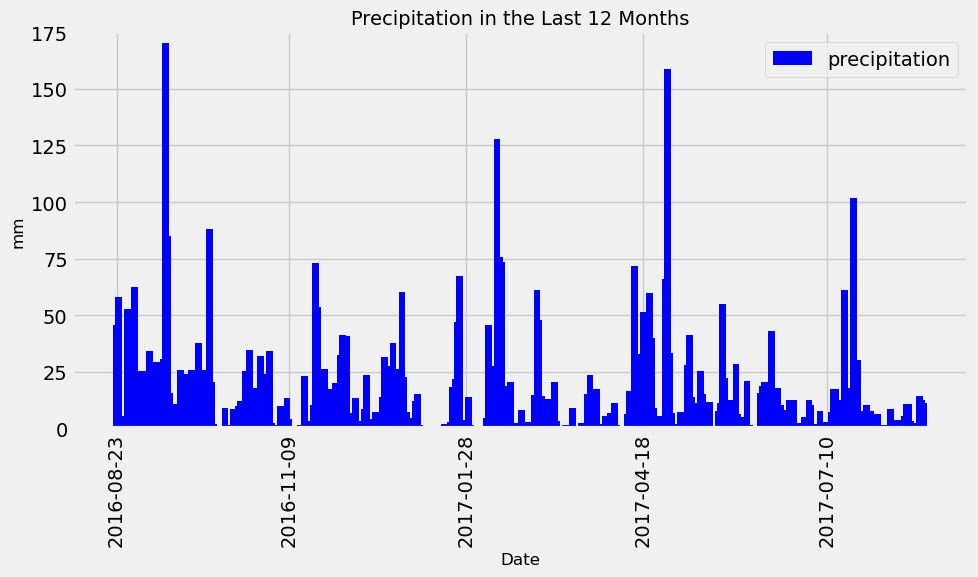

In [48]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
from datetime import datetime, timedelta

if isinstance(most_recent_date, str):
    most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')

one_year_ago = most_recent_date - timedelta(days=366)

# Perform a query to retrieve the data, precipitation scores, and station
precipitation_data = session.query(Measurement.date, Measurement.prcp, Station.station, Measurement.tobs).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation', 'Station', 'Tobs'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='Date')
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'])

# Use Pandas Plotting with Matplotlib to plot the data (excluding 'Station' column)
x_ticks = ['2016-08-23', '2016-11-09', '2017-01-28', '2017-04-18', '2017-07-10']
x_ticks = pd.to_datetime(x_ticks)
plt.figure(figsize=(10, 6))
plt.bar(precipitation_df['Date'], precipitation_df['Precipitation'], width=3, color='b', align='center')
plt.xlabel('Date', fontsize=12)
plt.ylabel('mm', fontsize=12)
plt.title('Precipitation in the Last 12 Months', fontsize=14)
plt.ylim(0, 175)
plt.yticks(np.arange(0, 176, 25))
plt.xticks(x_ticks, rotation=90)
plt.legend(['precipitation'], loc='best')
plt.tight_layout()
plt.show()

In [49]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precipitation_df['Precipitation'].describe()
summary_stats_df = summary_stats.to_frame()
summary_stats_df

,Precipitation
count,18189.000000
mean,4.505888
std,11.710910
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [50]:
# Design a query to calculate the total number of stations in the dataset
total_stations = precipitation_df['Station'].nunique()
print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [51]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station).label('count')).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")

most_active_station_id = active_stations[0][0]

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [52]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temperature_stats = session.query(
    func.min(Measurement.tobs).label('min_temp'),
    func.max(Measurement.tobs).label('max_temp'),
    func.avg(Measurement.tobs).label('avg_temp')
).filter(Measurement.station == most_active_station_id).all()

min_temp = temperature_stats[0].min_temp
max_temp = temperature_stats[0].max_temp
avg_temp = temperature_stats[0].avg_temp

print(f"Station ID: {most_active_station_id}")
print(f"Lowest Temperature: {min_temp}")
print(f"Highest Temperature: {max_temp}")
print(f"Average Temperature: {avg_temp}")

Station ID: USC00519281
Lowest Temperature: 12.2
Highest Temperature: 29.4
Average Temperature: 22.03582251082252


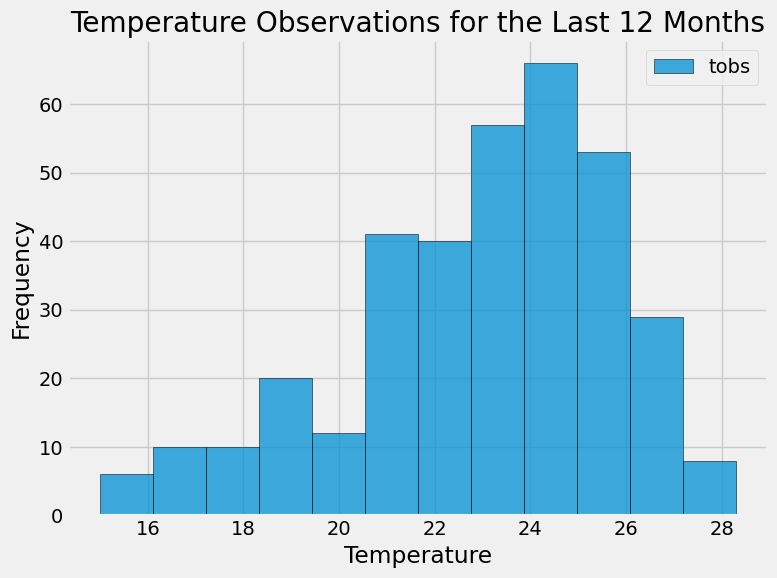

In [54]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

if isinstance(most_recent_date, str):
    most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')

one_year_ago = most_recent_date - timedelta(days=366)

temperature_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

temperature_df = pd.DataFrame(temperature_data, columns=['Date', 'Tobs'])
temperature_df['Date'] = pd.to_datetime(temperature_df['Date'])

plt.figure(figsize=(8, 6))
plt.hist(temperature_df['Tobs'], bins=12, edgecolor='k', alpha=0.75)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Observations for the Last 12 Months')
plt.legend(['tobs'])
plt.tight_layout()
plt.show()

# Close Session

In [55]:
# Close Session
session.close()
